In [ ]:
# %config Completer.use_jedi = False

In [ ]:
%config Completer.use_jedi = True

In [39]:
# Import Libraries
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [41]:
# Load Data
df_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv")

In [42]:
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [43]:
# Show the head of the data_dict
df_data_dict.head()

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN


In [44]:
# Show the shape of the data_dict
df_data_dict.shape

(59, 4)

In [45]:
# Show the number of type values
df_data_dict["type"].value_counts()

type
Categorical    36
Numerical      23
Name: count, dtype: int64

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [47]:
# Numerical Features
num_cols = \
    df_data_dict.query("type == 'Numerical'")["variable"].to_list()
print(num_cols)

['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'efs_time']


In [48]:
# Categorical Features
cat_cols = \
    df_data_dict.query("type == 'Categorical'")["variable"].to_list()
print(cat_cols)

['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'efs']


In [49]:
# Categorical Features
cat_feat_cols = cat_cols.copy()
cat_feat_cols.remove("efs")

In [50]:
# Show the Correlations
df_train[num_cols+["efs"]].corr(method="spearman").sort_values(by="efs")

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs_time,efs
efs_time,0.022269,0.026656,0.015745,0.025985,0.021514,0.012581,0.029183,0.034575,-0.007695,0.011532,...,-0.173477,0.041624,0.033254,-0.169469,0.131331,0.021245,-0.008801,0.019033,1.000000,-0.854608
year_hct,-0.165940,-0.167172,-0.165581,-0.160990,-0.157647,-0.118577,-0.148437,-0.161431,-0.153395,-0.120193,...,-0.002273,-0.144055,-0.153105,0.087344,-0.021893,-0.169952,-0.152857,-0.164340,-0.127900,-0.111288
karnofsky_score,-0.021133,-0.035744,-0.045764,-0.040003,-0.041471,-0.036979,-0.043543,-0.021491,-0.058323,-0.036946,...,-0.225969,-0.027970,-0.019760,-0.176462,1.000000,-0.042145,-0.051808,-0.048056,0.131331,-0.095293
hla_match_a_low,0.600850,0.767487,0.866286,0.773994,0.758812,0.549215,0.789948,0.602518,0.646207,0.507520,...,0.022552,1.000000,0.632686,0.013560,-0.027970,0.845052,0.657811,0.827219,0.041624,0.014448
hla_match_a_high,0.582152,0.835034,0.760093,0.852039,0.816996,0.540448,0.776006,0.588191,0.625989,0.507189,...,0.028180,0.773548,0.624551,0.016968,-0.031613,0.751957,0.636090,0.745978,0.043460,0.014572
hla_match_c_low,0.763150,0.753975,0.734740,0.732501,0.750171,0.623844,0.712726,1.000000,0.696079,0.597883,...,-0.024565,0.602518,0.724441,-0.024252,-0.021491,0.813240,0.695412,0.799049,0.034575,0.016010
hla_match_b_high,0.722908,0.870143,0.763559,0.872385,0.851387,0.613872,0.741941,0.724441,0.689565,0.576801,...,-0.013516,0.632686,1.000000,-0.013168,-0.019760,0.781454,0.710073,0.780986,0.033254,0.026131
hla_match_c_high,1.000000,0.798161,0.726872,0.726420,0.781402,0.629183,0.706515,0.763150,0.697563,0.611841,...,-0.018349,0.600850,0.722908,-0.033271,-0.021133,0.746018,0.700355,0.745326,0.022269,0.032399
hla_match_dqb1_low,0.611841,0.632537,0.621898,0.619725,0.648812,0.608899,0.609515,0.597883,0.619952,1.000000,...,0.018958,0.507520,0.576801,-0.036671,-0.036946,0.630376,0.621037,0.741613,0.011532,0.032519
hla_match_dqb1_high,0.629183,0.671300,0.668209,0.660082,0.778352,1.000000,0.647041,0.623844,0.666231,0.608899,...,0.028155,0.549215,0.613872,-0.039891,-0.036979,0.674659,0.656439,0.689202,0.012581,0.040572


## Feature Engineering for Categorical Features

### Interaction Terms

In [51]:
df_train["dri_score"] + "_" + df_train["psych_disturb"]

0        N/A - non-malignant indication_No
1                          Intermediate_No
2        N/A - non-malignant indication_No
3                                  High_No
4                                  High_No
                       ...                
28795                                  NaN
28796                              High_No
28797                                  NaN
28798    N/A - non-malignant indication_No
28799                   N/A - pediatric_No
Length: 28800, dtype: object

In [52]:
# Easy function
def merge_two_columns(df:pd.DataFrame, col_1:str, col_2:str):
    return df[col_1].copy() + "_" + df[col_2].copy()

In [53]:
merge_two_columns(df=df_train, col_1="donor_related", col_2="cmv_status").nunique()

12

In [54]:
df_train.shape

(28800, 60)

In [55]:
# Generate Inter effect columns
additional_cat_cols_all = []
for i, col_1 in enumerate(cat_feat_cols):
    for j, col_2 in enumerate(cat_feat_cols):
        if i > j:
            new_categorical_col = col_1 + "_" + col_2
            additional_cat_cols_all.append(new_categorical_col)
            df_train[new_categorical_col] = merge_two_columns(df=df_train, col_1=col_1, col_2=col_2)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [56]:
# Add 
cat_feat_cols.extend(additional_cat_cols_all)

In [37]:
X.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,pulm_moderate_peptic_ulcer,pulm_moderate_gvhd_proph,pulm_moderate_rheum_issue,pulm_moderate_sex_match,pulm_moderate_race_group,pulm_moderate_hepatic_mild,pulm_moderate_tce_div_match,pulm_moderate_donor_related,pulm_moderate_melphalan_dose,pulm_moderate_cardiac
0,7,0,7,0,NaN,NaN,0,0,6.0,0,...,No_No,No_FKalone,No_No,No_M-F,No_More than one race,No_No,NaN,No_Unrelated,"No_N/A, Mel not given",No_No
1,2,0,1,0,2.0,8.0,6,0,6.0,1,...,Yes_No,Yes_Other GVHD Prophylaxis,Yes_No,Yes_F-F,Yes_Asian,Yes_No,Yes_Permissive mismatched,Yes_Related,"Yes_N/A, Mel not given",Yes_No
2,7,0,7,0,2.0,8.0,0,0,6.0,0,...,No_No,No_Cyclophosphamide alone,No_No,No_F-M,No_More than one race,No_No,No_Permissive mismatched,No_Related,"No_N/A, Mel not given",No_No
3,0,0,1,0,2.0,8.0,0,0,6.0,0,...,No_No,No_FK+ MMF +- others,No_No,No_M-M,No_White,No_Yes,No_Permissive mismatched,No_Unrelated,"No_N/A, Mel not given",No_No
4,0,0,7,0,2.0,8.0,0,0,6.0,1,...,No_No,No_TDEPLETION +- other,No_No,No_M-F,No_American Indian or Alaska Native,No_No,No_Permissive mismatched,No_Related,No_MEL,No_No


In [68]:
# base_model = cat.CatBoostClassifier(verbose=0, cat_features=cat_feat_cols)
# base_model = lgb.LGBMClassifier(verbose=0, categorical_feature=cat_feat_cols)
base_model = lgb.LGBMClassifier(verbose=0)

In [69]:
# Fit a Model
base_model.fit(X=X, y=y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMClassifier(verbose=0)

In [80]:
gains_categorical_features = base_model.booster_.feature_importance(importance_type='gain')

In [108]:

np.quantile(gains_categorical_features[gains_categorical_features > 0], q=0.9)

170.99661946296692

In [114]:
top_features = X.columns[np.where(gains_categorical_features > 80)]
len(top_features)

125

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

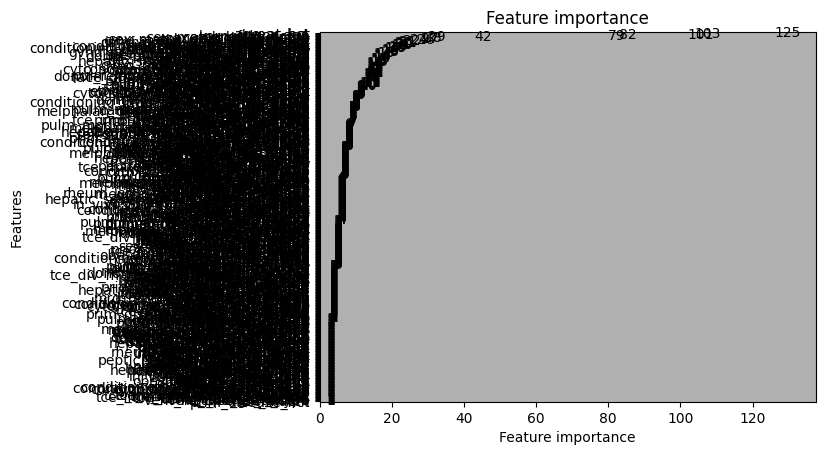

In [74]:
lgb.plot_importance(booster=base_model)

In [ ]:
# 
def create_interaction(df:pd.DataFrame, cat_features:list):
    """
    """
    pass

In [ ]:
# Compare the difference between Nan and Non Nan values, by conducting chi squared tests
for col in num_cols:
    mean_nan = df_train.query(f"~{col}.isnull()")["efs"].mean()
    mean_non_nan = df_train.query(f"{col}.isnull()")["efs"].mean()

    print(col, mean_nan, mean_non_nan)

In [ ]:
# Chi Squared Test for Nan or Non Nan
for col in num_cols:
    tf_int_nan = df_train[col].isnull().astype("int")
    crossed = pd.crosstab(df_train["efs"], tf_int_nan)

    if df_train[col].isnull().sum() == 0:
        continue
    x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
    print(col, p)

In [ ]:
# Plot a heatmap
sns.heatmap(df_train[num_cols+["efs"]])

In [ ]:
# Plot the differences between categorical features
for col in cat_cols:
    print(df_train.groupby([col]).agg({"efs":"mean", "efs_time":"count"}))

In [ ]:
# Conduct chi square test with the categorical features
for col in cat_cols:
    if col == "efs":
        continue
        
    crossed = df_train.pivot_table(index="efs", columns=col, aggfunc="count", values="efs_time")
    x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
    print(col, p)

In [ ]:
# See the realations between numerical features and the target value
# Plot 

## Create a Basic Machine Learning Model

In [57]:
# Define Data
X = df_train.drop(columns=["ID", "efs", "efs_time"])
y = df_train[["efs"]]

In [58]:
# Convert categorical features by conducting label encoding
for col in cat_feat_cols:
    if col == "efs":
        continue
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [98]:
# Split the Data Sets into train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [132]:
# Train with basic light GBDT Models
cat_model = cat.CatBoostClassifier(verbose=0)
cat_model.fit(X_train[top_features], y_train)
cat_pred = cat_model.predict_proba(X_test[top_features])[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=cat_pred))

ROC AUC: 0.7550134729188286


In [138]:
[col for col in cat_top_features if col not in cat_cols]

['psych_disturb_dri_score',
 'cyto_score_dri_score',
 'diabetes_dri_score',
 'tbi_status_dri_score',
 'tbi_status_psych_disturb',
 'tbi_status_cyto_score',
 'graft_type_cyto_score',
 'graft_type_tbi_status',
 'pulm_severe_psych_disturb',
 'pulm_severe_diabetes',
 'pulm_severe_tbi_status',
 'pulm_severe_vent_hist',
 'prim_disease_hct_dri_score',
 'prim_disease_hct_tbi_status',
 'prim_disease_hct_vent_hist',
 'prim_disease_hct_renal_issue',
 'cmv_status_dri_score',
 'cmv_status_prim_disease_hct',
 'tce_imm_match_cmv_status',
 'rituximab_dri_score',
 'prod_type_dri_score',
 'prod_type_cyto_score',
 'prod_type_graft_type',
 'prod_type_prim_disease_hct',
 'prod_type_cmv_status',
 'cyto_score_detail_cyto_score',
 'cyto_score_detail_arrhythmia',
 'cyto_score_detail_prim_disease_hct',
 'cyto_score_detail_cmv_status',
 'conditioning_intensity_dri_score',
 'conditioning_intensity_tbi_status',
 'conditioning_intensity_graft_type',
 'conditioning_intensity_vent_hist',
 'conditioning_intensity_prim

In [101]:
X_train[top_features]

,dri_score,hla_low_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,...,melphalan_dose_gvhd_proph,cardiac_cyto_score,cardiac_pulm_severe,cardiac_prim_disease_hct,cardiac_cmv_status,cardiac_cyto_score_detail,cardiac_conditioning_intensity,pulm_moderate_cyto_score_detail,pulm_moderate_gvhd_proph,pulm_moderate_sex_match
1988,9,6.0,NaN,NaN,NaN,2016,NaN,38.831,2.0,51.252,...,8,20,0,11,3,15,0,15,8,3
2029,2,6.0,10.0,2.0,6.0,2017,2.0,49.971,2.0,63.235,...,24,1,0,1,3,1,4,1,8,3
6082,2,5.0,9.0,2.0,6.0,2008,2.0,66.390,1.0,18.321,...,9,1,0,2,0,1,0,1,9,1
6826,9,6.0,10.0,2.0,6.0,2018,2.0,60.394,2.0,11.482,...,24,0,0,9,0,3,0,3,8,2
9666,2,3.0,8.0,2.0,4.0,2015,1.0,39.457,1.0,0.044,...,23,6,0,1,1,15,0,15,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11689,2,6.0,10.0,2.0,6.0,2011,2.0,66.677,2.0,65.096,...,8,1,0,1,0,1,2,1,8,3
19876,0,4.0,7.0,2.0,5.0,2016,1.0,28.717,1.0,35.421,...,7,6,0,2,0,0,0,0,7,1
2177,0,6.0,7.0,1.0,5.0,2016,1.0,42.677,2.0,29.575,...,24,0,0,1,0,1,0,11,37,11
11749,0,6.0,10.0,2.0,6.0,2015,2.0,21.073,2.0,11.929,...,24,5,0,2,3,0,0,0,8,2


In [115]:
%%time
# Train with basic GBDT Models
cat_top_features = [col for col in top_features if col in cat_feat_cols]
cat_model = cat.CatBoostClassifier(verbose=0, cat_features=cat_top_features)
cat_model.fit(X_train[top_features], y_train)
cat_pred = cat_model.predict_proba(X_test[top_features])[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=cat_pred))

ROC AUC: 0.7545532140763245
CPU times: user 15min 34s, sys: 1min 9s, total: 16min 44s
Wall time: 4min 35s


100%|===================| 7187/7200 [03:51<00:00]        

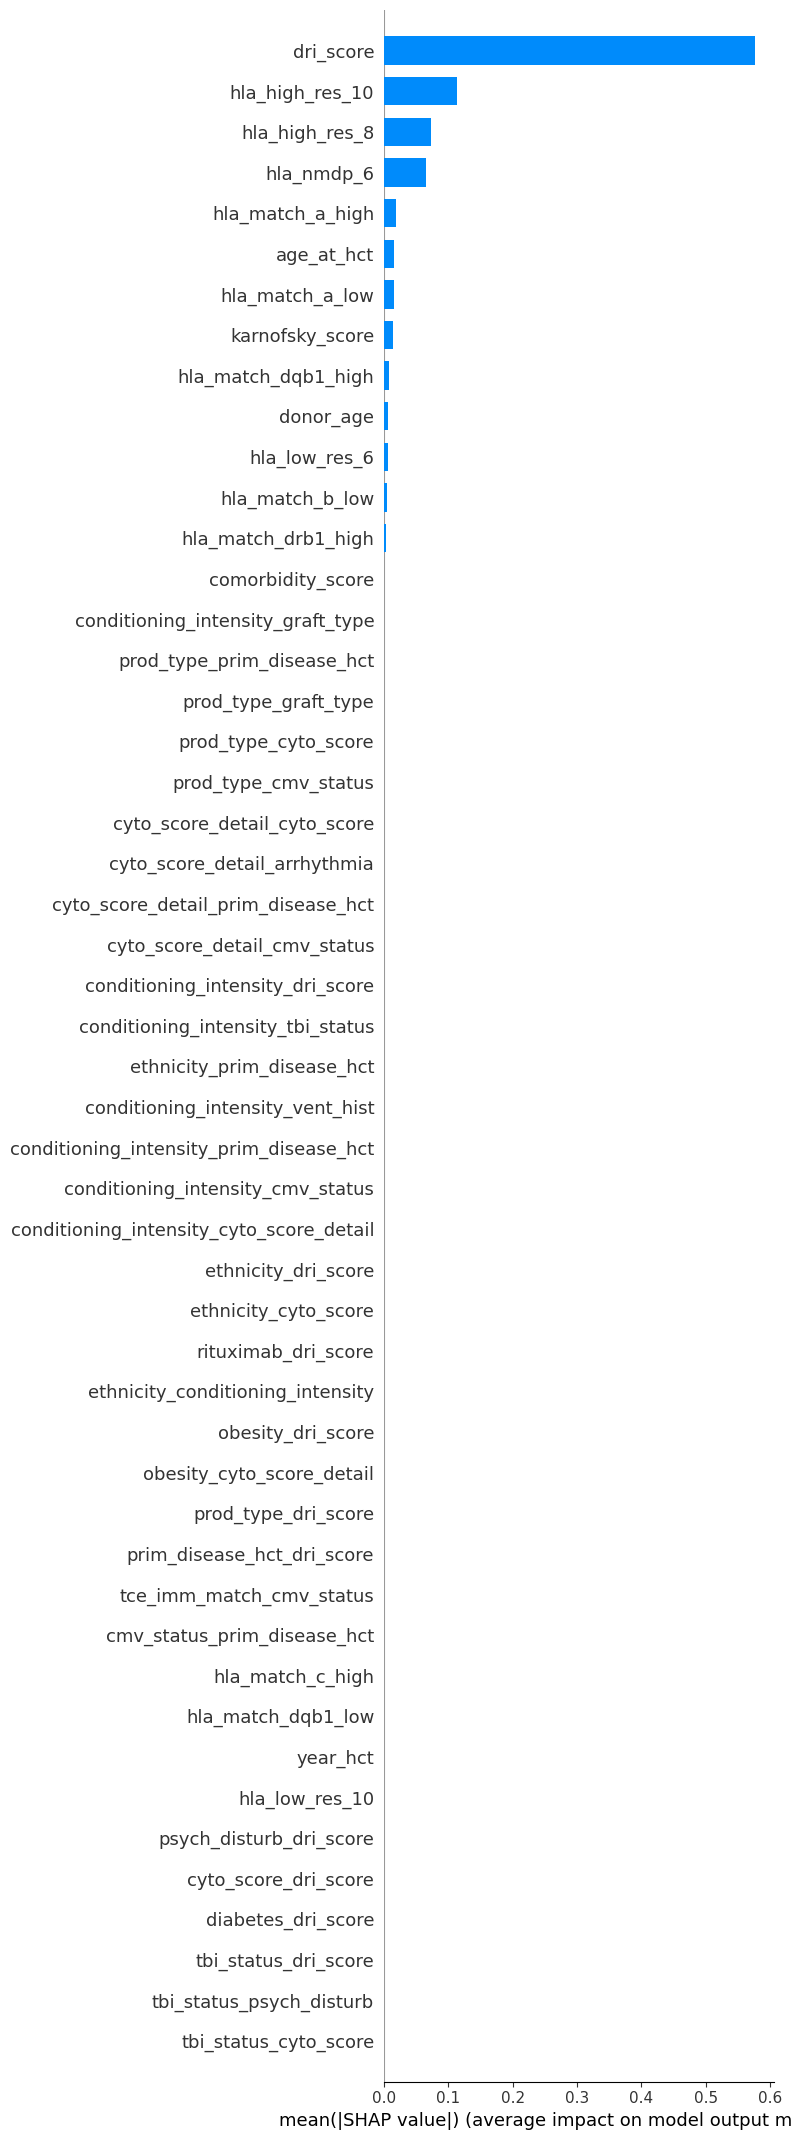

In [116]:
# Plot Important Features for the Catboost Model
explainer = shap.TreeExplainer(model=cat_model, data=X_test[top_features])
shap_values = explainer.shap_values(X=X_test[top_features])
shap.summary_plot(shap_values=shap_values, features=X_test[top_features], plot_type="bar", max_display=50)

In [130]:
pd.DataFrame(shap_values, columns=top_features).apply(lambda x: abs(x)).sum().sort_values(ascending=False)[:50]

dri_score                            4152.904388
hla_high_res_10                       817.932119
hla_high_res_8                        524.991905
hla_nmdp_6                            471.128910
hla_match_a_high                      129.908124
age_at_hct                            115.748131
hla_match_a_low                       113.679519
karnofsky_score                        98.627205
hla_match_dqb1_high                    56.660004
donor_age                              49.962631
hla_low_res_6                          47.973222
hla_match_b_low                        39.298878
hla_match_drb1_high                    19.298008
comorbidity_score                       4.709003
race_group_cyto_score                   0.000000
sex_match_cmv_status                    0.000000
sex_match_diabetes                      0.000000
sex_match_tbi_status                    0.000000
sex_match_pulm_severe                   0.000000
sex_match_prim_disease_hct              0.000000
sex_match_gvhd_proph

In [107]:
cat_top_features

['dri_score',
 'cyto_score_dri_score',
 'tbi_status_dri_score',
 'tbi_status_psych_disturb',
 'tbi_status_cyto_score',
 'graft_type_cyto_score',
 'graft_type_tbi_status',
 'pulm_severe_diabetes',
 'pulm_severe_tbi_status',
 'prim_disease_hct_dri_score',
 'prim_disease_hct_tbi_status',
 'prim_disease_hct_vent_hist',
 'prim_disease_hct_renal_issue',
 'cmv_status_dri_score',
 'cmv_status_prim_disease_hct',
 'tce_imm_match_cmv_status',
 'rituximab_dri_score',
 'prod_type_dri_score',
 'prod_type_cyto_score',
 'prod_type_graft_type',
 'prod_type_prim_disease_hct',
 'prod_type_cmv_status',
 'cyto_score_detail_cyto_score',
 'cyto_score_detail_arrhythmia',
 'cyto_score_detail_prim_disease_hct',
 'conditioning_intensity_dri_score',
 'conditioning_intensity_tbi_status',
 'conditioning_intensity_graft_type',
 'conditioning_intensity_vent_hist',
 'conditioning_intensity_prim_disease_hct',
 'conditioning_intensity_cmv_status',
 'conditioning_intensity_cyto_score_detail',
 'ethnicity_dri_score',
 'et

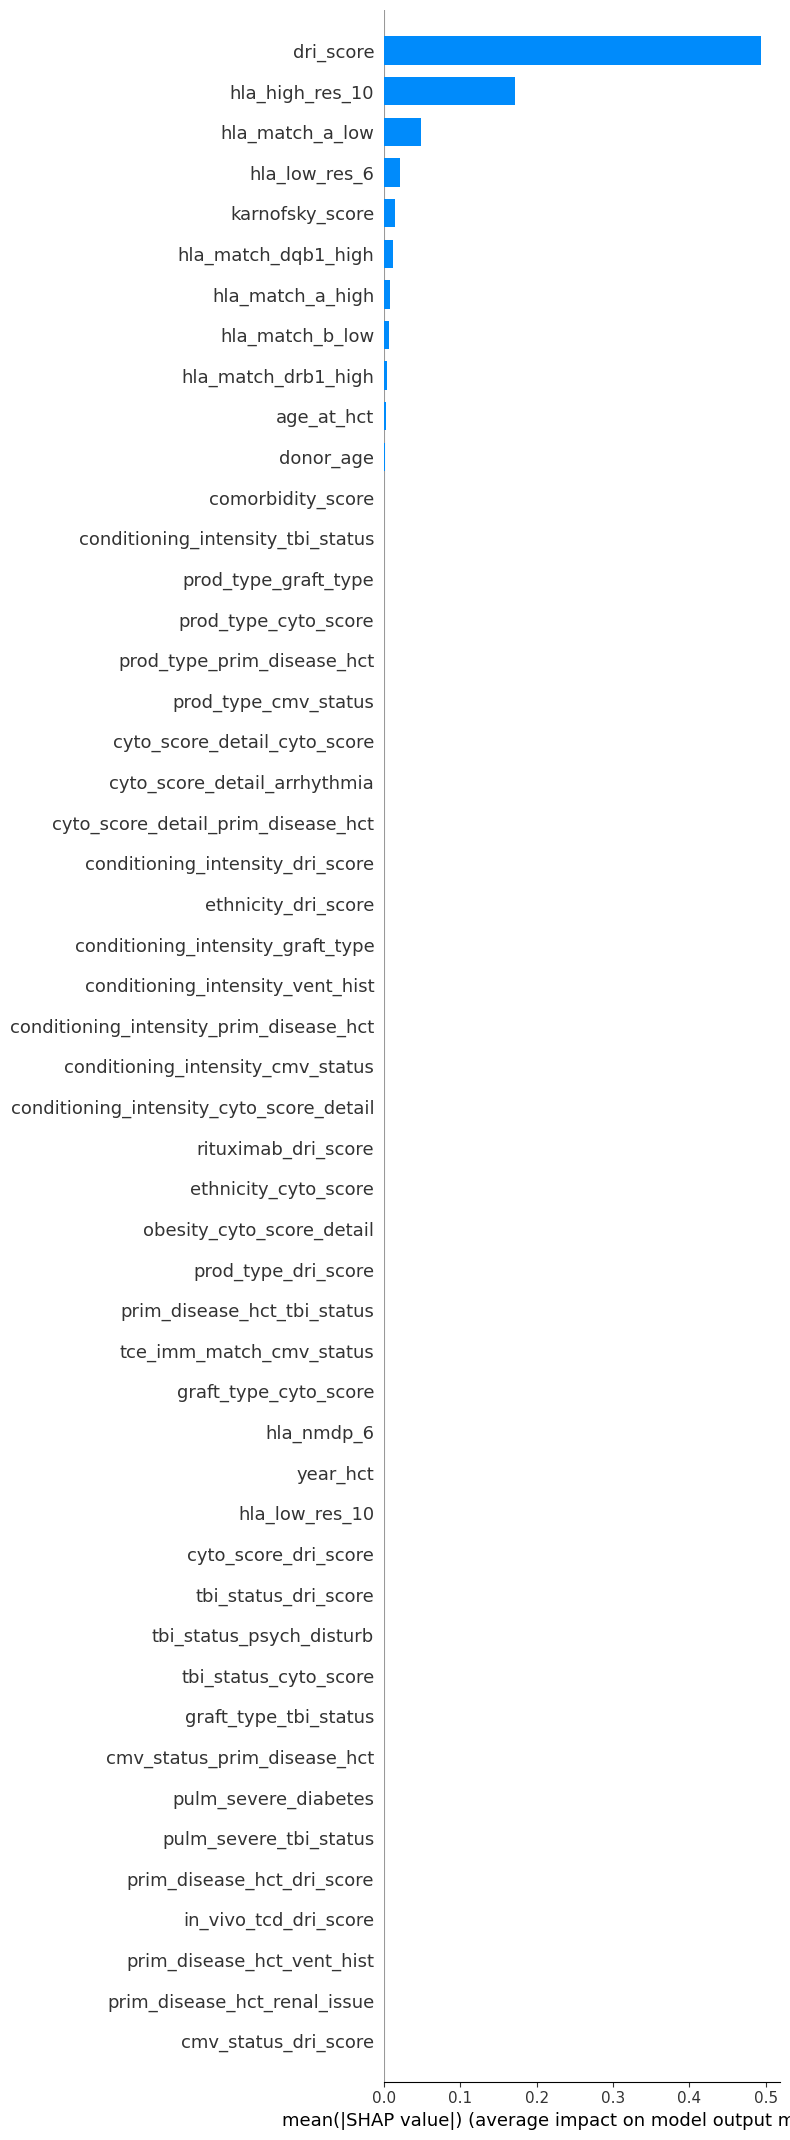

In [ ]:
def plot_shap(model, X_test):
    """
    Plot a summary plot of the shap values
    """
    explainer = shap.TreeExplainer(model=model, data=X_test)
    shap_values = explainer.shap_values(X=X_test)
    shap.summary_plot(shap_values=shap_values, features=X_test, plot_type="bar", max_display=30)

In [ ]:
# Train with basic light GBDT Models
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=lgb_pred))

In [ ]:
# Train with basic XGBoost Model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=xgb_pred))

In [ ]:
plot_shap(model=xgb_model, X_test=X_test)

In [ ]:
# Train with Random Forest Classifier
X_train_no_nan = X_train.fillna(-1)
X_test_no_nan = X_test.fillna(-1)

rf_model = RandomForestClassifier()
rf_model.fit(X_train_no_nan, y_train)
rf_pred = rf_model.predict_proba(X_test_no_nan)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=rf_pred))

## Conduct Cross Validation

In [ ]:
# Here, we would like to conduct cross validation to find the assumed best model
kf = KFold(n_splits=4)
list_scores = []
for train_idx, val_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train with basic light GBDT Models
    cat_model = cat.CatBoostClassifier(verbose=0, cat_features=cat_cols)
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_true=y_test, y_score=cat_pred)
    list_scores.append(score)
    print("ROC AUC:", score)
print("Average ROC AUC:", np.mean(list_scores))

In [ ]:
def conduct_cross_validation(model, X, y):
    """
    Conduct Cross Validation and Calculate Average ROC AUC Score
    """
    kf = KFold(n_splits=4)
    list_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train with basic light GBDT Models
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_true=y_test, y_score=pred_proba)
        list_scores.append(score)
        print("ROC AUC:", score)
    print("Average ROC AUC:", np.mean(list_scores))    

In [ ]:
# CV by LightGBM
model_lgb = lgb.LGBMClassifier(verbose=0)
conduct_cross_validation(model=model_lgb, X=X, y=y)

In [ ]:
# CV by XGBoost
model_xgb = xgb.XGBClassifier()
conduct_cross_validation(model=model_xgb, X=X, y=y)

In [ ]:
# CV by Catboost with categorical feature
cat_model_1 = cat.CatBoostClassifier(verbose=0, cat_features=cat_cols)
conduct_cross_validation(model=cat_model_1, X=X, y=y)

In [ ]:
# CV by Catboost without categorical feature
cat_model_2 = cat.CatBoostClassifier(verbose=0)
conduct_cross_validation(model=cat_model_2, X=X, y=y)

In [ ]:
# From the result above, I conclude that catboost would peroform the best, and it would be good to use cat_features parameter

## Explore Data

In [ ]:
# The number of nan or Not Done values
df_train["count_nan_vals"] = df_train.isnull().sum(axis=1)

In [ ]:
sns.histplot(data=df_train, x="count_nan_vals", hue="efs")

In [ ]:
df_train.groupby("count_nan_vals")["efs"].mean()

In [ ]:
# The plot above indicates the more null values, the less the patients are likely to survive

In [ ]:
df_train["count_not_done_vals"] = (df_train == "Not done").sum(axis=1)

In [ ]:
sns.histplot(data=df_train, x="count_not_done_vals", hue="efs")

In [ ]:
# 
df_train.groupby("count_not_done_vals")["efs"].mean()

In [ ]:
# It seems that the more not done vals, the less the patients are likely to survive

In [ ]:
!pip install jedi

In [ ]:
%config Completer.use_jedi = True

In [ ]:
df_train.shape